In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from scipy.optimize import minimize # Python version of R's optim() function
from sklearn import datasets

In the next exercises you will implement neural networks of various complexity from scratch. You will

1. Implement Rosenblatt's perceptron learning algorithm
2. Implement a multilayer perceptron with two hidden layers
3. Implement gradient descent learning rule


# Rosenblatt's Perceptron Learning Algorithm

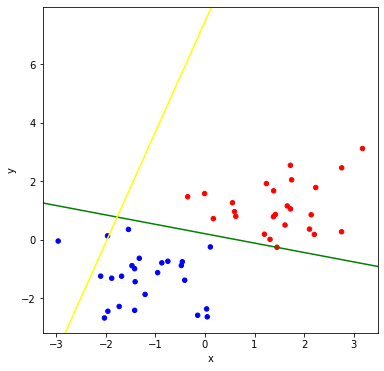

Let's implement Rosenblatt's Perceptron learning algorithm. The algorithm is described by


> 1. Start with an initial guess $\mathbf{w} = \mathbf{w}_0$
> 2. For every input pattern $\mathbf{x}_i$:
>     1. with the current weights $\mathbf{w}$ predict its class with $d_i \leftarrow \mathrm{sign}(\mathbf{x}_i\cdot\mathbf{w})$
>     2. update the weights by $\mathbf{w} \leftarrow \mathbf{w} + \eta\cdot(y_i-d_i)$
> 3. Repeat 2. many times (until convergence)

Step 3 tells us to repeat Step 2 many times. Tranlated to R and Python this takes the form of nested loops: An **inner loop**, which iterates over the input patterns, and an **outer loop** which repeats the inner loop many times.

The key contribution of Rosenblatt's algorithm is Step 2B in which the weights $\mathbf{w}$ are updated as the algorithm sees a new observation. This equation for uptdating $\mathbf{w}$ is called a _learning rule_. 

You are going implement Rosenblatt's algorithm to replicate boundary seperation in the image in the lecture slides. To do so, first let's generate the data in the image:

In [ ]:
# Set the seed of the random number generator
np.random.seed(19)

# Generate features of cases and store them in the matrix X
Xa = np.random.normal(loc=+1.2, size=(25,2))
Xb = np.random.normal(loc=-1.2, size=(25,2))
X = np.vstack([Xa, Xb])
X = np.hstack([np.ones((X.shape[0],1)), X])

# Generate target labels: -1 for blue, 1 for read
n = X.shape[0]
y = [-1 if i < n//2 else 1 for i in range(n)]

# Plot the observations
col = ['blue' if value > 0 else 'red' for value in y] # color of the points (-1: blue, +1: red)
ax = pd.DataFrame(X[:,1:], columns=['x','y']).plot('x','y',kind='scatter',figsize=(6,6),c=col)

Using these simulated data you're going to implement Rosenblatt's algorithm above to find a decision boundary that seperates the blue and red observations. In the inner loop, for each input pattern `X[i]` and target label `y[i]` you will have to complete Steps A and B. For Step A you have to first compute the dot product $\mathbf{w}\cdot \mathbf{x}_i$ and then take the sign of the resulting value (using the `np.sign` function) and storing the value in a variable `d_i`. For Step B you have to update `w` as in the equation.

## Exercise 🧠🦾

Implement Rosenblatt's algorithm using the following structure:

1. _Note_: Step 1 is already completed for you.
2. Use an **outer `for` loop** that runs for 10,000 iterations (this implements Step 3).
3. Within this outer loop, use an **inner `for` loop** to go through each observation in `(X, y)` (this implements Step 2).


Ensure that the outer loop repeats the algorithm to drive convergence, and the inner loop processes each observation individually.


<details>
    <summary><b>Click if you're stuck</b></summary>
    You can type over the code from the slides.
</details>

In [ ]:
# Your code to implement Rosenblatt's algorithm (see above)

# Step 1
w0 = np.array([-14,-7,2])
eta = 0.001

# Steps 2 and 3
w = w0.copy()

for _ in range(10_000):
    for i in range(len(X)):
        x = X[i]
        d = np.sign(x.dot(w))
    w = w + eta * (y[i] - d)
        
# print the set of weights found by Rosenblatt's algorithm
print(w)

The values in `w` probably don't mean anything to you, but they represent the decision boundary. With some math we can plot the corresponding decision boundary in a scatter plot of the points:

In [ ]:
# Visualize: Result should look like figure above
col = ['blue' if value > 0 else 'red' for value in y] # color of the points (-1: blue, +1: red)
ax = pd.DataFrame(X[:,1:], columns=['x','y']).plot('x','y',kind='scatter',figsize=(6,6),c=col)

# Add the line that is the decision boundary found by the algorithm and the line that we started with
line_start = ax.axline((0,7), slope = 3.5, c='yellow')
line_end   = ax.axline((0,-w[0]/w[2]), slope = -w[1]/w[2], c='green')

# Add a legend
ax.legend([line_start, line_end], ['boundary at start', 'boundary determined by Rosenblat\'s algorithm']) # Adding legend

The line that we started with clearly did not separate the blue and red observations. The line found by the algorithm did! (_If it didn't, you may have made a mistake in your implementation, or you started from a different point._)

# Multilayer perceptron




Rosenblatt's algorithm only works for a network with two layers and cannot be applied to networks with more than two layers. This limitation exists because there is no equivalent weight update rule (learning rule) for networks with three or more layers. This is problematic since a two-layer network cannot solve the XOR problem, meaning it cannot learn nonlinear decision boundaries. In contrast, a three-layer network *can* learn nonlinear boundaries if each neuron has a nonlinear activation function. In fact, it has been proven that a three-layer network can learn *any* form of nonlinear boundary, provided there are enough neurons in the middle (or *hidden*) layer and their activation functions are nonlinear.

An example of a multilayer neural network (also called a *feed-forward network*, *multilayer perceptron*, or *MLP*) is shown in the diagram below.

Since Rosenblatt's learning rule is not applicable to these multi-layer networks, we need a different learning rule. Most learning rules that have been proposed, including the so called _delta rule_ and now ubiquitous _backpropagation_ learning rule, can be formulated as updating the weight vector $\mathbf{w}$ such that it reduces a *loss function* at every step. This insight is highly beneficial because it allows us to use well-established mathematical optimization techniques to learn a $\mathbf{w}$ that allows the network to predict the target label. The problem is then, instead of finding a completely new learning rule for an MLP, we only need to define an appropriate loss function. Common choices for the loss function include the mean squared error (MSE), used for regression problems, and the *categorical cross-entropy* loss, which is the log-likelihood function familiar from multinomial regression.

Optimization is a well-studied field in mathematics, and there are general numerical methods available to optimize (minimize or maximize) functions. These methods are conveniently provided as built-in functions, such as `minimize` in Python and `optim` in R.

In the following exercises, you will implement an MLP and train it on a well-known dataset to predict diabetes.

#### Two hidden layer perceptron

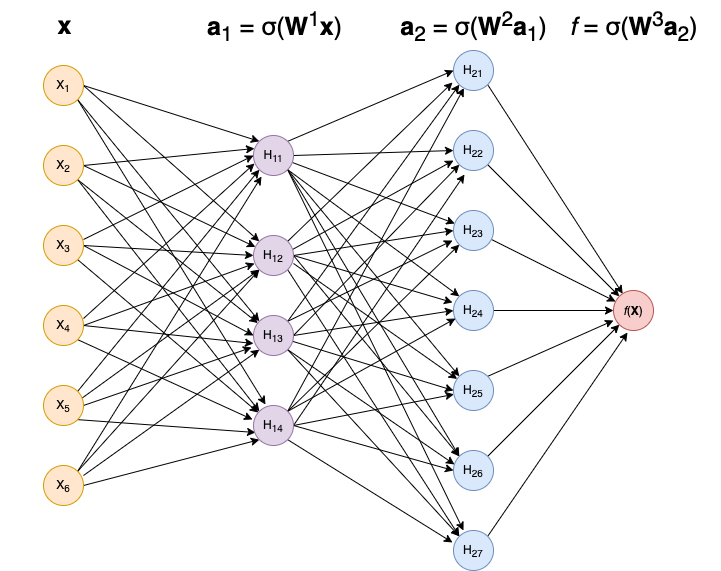



In the first exercise you'll implement the 2-hidden layer perceptron depicted here with a series of matrix multiplications. It will take the form of a function that accepts input and returns the output value of the MLP given a set of weights and matrix with observed input patterns. In the subsequent exercises you will fit it to data using the `minimize()` function from the `scipy.optimize` module.

The MLP you'll create has

- 6 input units
- 4 hidden units in the first layer
- 7 hidden units in the second layer
- 1 output unit

This is slightly simplified, because the _biases_ are missing. However, it will still give you a deep understanding of what is happening under the hood of a multilayer perceptron (aka _feed forward network_).

In matrix notation, the network is described by the following equations:

1. $\mathbf{a}_1 = \sigma(\mathbf{W}^1 \mathbf{x})$
2. $\mathbf{a}_2 = \sigma(\mathbf{W}^2 \mathbf{a}_1)$
3. $\mathbf{f} = \sigma(\mathbf{W}^3 \mathbf{a}_2)$



Here, $\sigma()$ represents the nonlinear activation function used for each neuron. In this exercise, we will use the $\tanh(x)$ function as $\sigma()$. The $\tanh(x)$ function is an S-shaped curve similar to the logistic function, but it differs in its range: it spans from -1 to +1, whereas the logistic function ranges from 0 to 1.

We need to implement these equations in code. This can be translated directly into Python or R using matrix multiplication.

An example implementation in R looks like this:

```R
my_mlp = function(w, X, sigma = tanh) {
   # Construct between layer connection weights matrices W1, W2, and W3
   W1 = matrix(w[1:(4*6)],4,6)
   W2 = matrix(w[1:(7*4)+6*4], 7, 4)
   W3 = matrix(w[1:7+4*6+7*4],1,7)
    
   # Implement the equations
   a1 = sigma(W1 %*% X)  #   input -> layer 1
   a2 = sigma(W2 %*% a1) # layer 1 -> layer 2
   f  = sigma(W3 %*% a2) # layer 2 -> output
    
   return(f)
}

```

This function takes as input 

- a vector `w` contains the values of all the weights of all layers, and 
- the matrix `X` in which each column contains the input features of each observation (that is, each column corresponds to an observation and each row corresponds to one of the 6 input features).
- optionally a activation function (which by default is `tanh`)

When the function is called, the matrices `W1`, `W2`, and `W3` are created, and the values of their elements are extracted from the input vector `w`.

Once the matrices are made, the matrix equations are implemented quite literally as in the mathematical expressions. 

The final result `f` is returned as the value of the function that the network implements.

The reason that all the weight values are passed to the function in a single vector has to do with how general optimization functions work, such as `optim` in R and `minimize` in Python. We will use `optimize` in the following exercise.

## Exercise 🧠🦾

Translate the above R code to Python (_do this by hand and **not** by ChatGPT!_) and test your function:

In translating from R to Python, remember the following equivalencies:

| R | Python | note |
|---|--------|------|
| `matrix` | `np.array` | make matrix out of list of numbers |
| `sign` | `np.sign` | prepend math functions in Python with `np.` |
| `sum` | `np.sum` | idem |
| `%*%`  | `@` | matrix multiplication |
| `^`    | `**` | raise to the power |
| `optim` | `minimize` |

Remember **in particular** that in are the elements of an array of $k$ elements in R are numberd 1, 2, 3, ..., k, while in Python they are numbered 0, 1, 2, ..., k-1.

<details>
    <summary><b>Click if you're stuck</b></summary>
    You can type over the code from the slides.
</details>

In [ ]:
def my_mlp(w, X, sigma=np.tanh):
    W1 = w[:4*6].reshape((4,6))
    W2 = w[W1.size:W1.size+7*4].reshape((7,4))
    W3 = w[W1.size+W2.size:W1.size+W2.size+1*7].reshape((1,7))
    a1 = sigma(W1 @ X)
    a2 = sigma(W2 @ a1)
    f = sigma(W3 @ a2)
    
    return f

# Tests
np.random.seed(123)
w = np.random.normal(size=(6*4 + 4*7 + 7)) # vector with input weight values
X = np.random.normal(size=(6,10)) # matrix with 6 feature values for each of 10 simulated observations
my_mlp(w, X)

If you translated the R function correctly, the output should be
```
array([[-0.8293042 , -0.26022696, -0.82222961, -0.32002817,  0.98262593,
         0.98724623,  0.98356712,  0.8642152 , -0.98754598,  0.802443  ]])
```


The function `my_mlp` accepts the connection weights of the network and the feature values as input, and outputs a predicted value.

As mentioned earlier, we will use a built-in general optimization function instead of Rosenblatt's learning rule. To train the network, we need to adjust the connection weights in `w` to minimize the difference between the network's predictions and the true values in `y`. To achieve this, we need a *loss function* to measure this difference. The most commonly used loss function is the Mean Squared Error (MSE), familiar from linear regression analysis:

$$
MSE = \sum_{i=1}^n (f(\mathbf{x}_i) - y_i)^2
$$

where $f(\mathbf{x}_i)$ is the output of the network for the input $\mathbf{x}_i$.

We also need to implement this in code. In both R and Python, the most efficient way to do this is using *vectorized* operations. An example implementation in R would look like this:


```R
MSE_func = function(w,X,y) {
   f = my_mlp(w,X)
   MSE = sum((f - y)^2)
   return(MSE)
}
```

## Exercise 🧠🦾 

Translate the above R code to Python and test it:

In [ ]:
def MSE_func(w, X, y): 
    f = my_mlp(w, X)
    MSE = np.sum((f-y) ** 2)
    return MSE

# Tests
np.random.seed(123)
w = np.random.normal(size=(6*4 + 4*7 + 7)) # vector with input weight values
X = np.random.normal(size=(6, 10)) # matrix with 6 feature values for each of 10 simulated observations
y = np.array([1 if i < X.shape[1]//2 else -1 for i in range(X.shape[1])]) # target labels
mse = MSE_func(w,X,y)
print(mse)

w = np.ones(shape=(6*4 + 4*7 + 7))
mse = MSE_func(w,X,y)
print(mse)

w = np.ones(shape=(6*4 + 4*7 + 7))
X = np.ones(shape=(6, 10))
mse = MSE_func(w,X,y)
print(mse)

The output of these tests should be

```
24.605763094113463
15.999973100543675
19.99996642509007
```

### Training the MLP 

With the functions `my_MLP()` and `MSE_func()` defined, we can train the MLP on data using built-in optimization functions in both R and Python.

In R, the `optim()` function is used for optimization tasks. It adjusts the parameters of a function to find its minimum (or maximum). You need to provide:

- **Initial values**: Starting parameter values.
- **Function to minimize**: The function being optimized.
- **Method** (optional): The algorithm to use (e.g., "BFGS", "Nelder-Mead").
- **Extra arguments to be passed**: Named extra arguments that are to be passed to the function being optimized (e.g. `X=X, y=y)`)

The method ('BFGS', 'Nelder-Mead') refers to different mathematical strategies. For Python the default method is 'BFGS' which is a _gradient_ based technique. For R the default is 'Nelder-Mead' which uses a different strategy. The gradient based technique is the computationally the most efficient and as a consequence the popular in deep learning (and at the heart of backpropagation).

Example in R:
```R
param_start <- c(1, 1)
result <- optim(param_start, fn=my_function)
```

Once `optim()` converges (which can take milliseconds to days) it returns a list that contains the optimal parameter values, the value of `my_function` at that value (presumably the minimum), the number of steps (iterations) it took to find the minimum, and convergence diagnostic code (which is 0 if the result is very likely a true minimum, but takes other values in case the maximum number of steps was reached or other problems occured during minimization).

In Python, `minimize()` from `scipy.optimize` works similarly:

- Pass **initial parameter guesses**.
- Define the **function to minimize**.
- Optionally a tuple with **extra arguments** to be passed in to the function being optimized (e.g. `(X,y)` as 2nd, 3rd argument)
- Optionally, specify the **method** (e.g., `'BFGS'`).

```python
from scipy.optimize import minimize
param_start = [1, 1]
result = minimize(my_function, param_start)
```

Both `optim()` in R and `minimize()` in Python work by iterating to find parameter values that minimize the output of the function.


In the next exercise you are going to fit the MLP on the famous diabetes data set of which we use the first 250 cases as the training set, and use only 6 features. The test set is an additional 192 cases.

In [ ]:
diabetes = datasets.load_diabetes() # famous 'diabetes' dataset
iris = datasets.load_iris()
X_train = diabetes['data'][:250,0:6] # use only the first 6 columns; transpose because cases should be in columns
y_train = diabetes['target'][:250]
cutoff = np.mean(y_train)
y_train = np.array([-1 if y_train[i] < cutoff else +1 for i in range(len(y_train))])

# Inspecting the data
pd.plotting.scatter_matrix(pd.DataFrame(X_train), c=y_train+2, figsize=(8,8));
pd.DataFrame({'y':y_train}).value_counts()

As can be seen, The observations fall into two classes: `-1` for "no diabetes" and `1` for "diabetes." About 45% of the cases are labeled as "diabetes." If we always predicted the majority class (`-1` or "no diabetes"), we would achieve an accuracy of approximately 55%. Let’s see if the MLP model can achieve a higher accuracy than this baseline.

#### Early stopping

Our MLP model has 59 parameters ($6 \times 4 + 4 \times 7 + 7 = 59$), which provides it with a high degree of flexibility. This flexibility, however, increases the risk of overfitting the data. To reduce this risk, we will use a common technique in deep learning called ***early stopping***. This involves limiting the number of training iterations—allowing only a limited number of steps in minimizing the loss function—rather than letting the algorithm reach the exact minimum of the loss function. The result is similar to ridge regularization, helping to prevent overfitting.

## Exercise 🧠🦾 

Use the `minimize` function from the `scipy.optimize` to train the MLP implemented by your `my_mlp` function on the diabetes data. Limit the number of iterations to 4.

To do this you have to call `minimize` with as its arguments your loss function and a starting value. In addition, you have to set the optional parameter `options` to `{'maxiter': 4}`.

In [ ]:
np.random.seed(123)
w_start = np.random.normal(size=(4*6 + 7*4 + 1*7))
fit = minimize(MSE_func, w_start, (X_train.T, y_train), options={'maxiter':4}) # fill in _, __, and ___

print(f"""loss function value: {fit['fun']},\n\nparams: {fit['x']}""")

Let's see how well the MLP can separate the diabetics from the non-diabetics by computing the proportion of correct classifications:

In [ ]:
# Compute the predicted values for the training set
pred = my_mlp(fit.x,X_train.T).squeeze() # squeeze drops unnecessary dimensions in an array (like 'drop()' in R)
pred = [-1 if pred[i] < 0 else +1 for i in range(len(pred))]

# Accuracy
np.mean(y_train == pred)

The accuracy is about 70% which is significantly higher than the 55% benchmark rate from naively predicting the majority class. Does this hold up in the test set though? Let's see:

In [ ]:
X_test = diabetes['data'][250:,0:6]
y_test = diabetes['target'][250:]
y_test = np.array([-1 if y_test[i] < cutoff else +1 for i in range(len(y_test))]) 

pred = my_mlp(fit.x, X_test.T).squeeze() 
pred = [-1 if pred[i] < 0 else +1 for i in range(len(pred))]
np.mean(y_test == pred)

It certainly does!

Congratulations! You’ve built a multilayer perceptron (MLP) from scratch, using matrix multiplications and vectorized operations to compute outputs from inputs. You’ve also successfully trained it on a well-known diabetes dataset to classify diabetics vs. non-diabetics using your own loss function and an optimization function.



This approach works well for small deep neural networks, like the one we’re using now. But it’s too slow to use for larger networks, even if we only increase the number of parameters by 5 times—much less for massive networks like GPT-3, which has millions or even hundreds of billions of parameters. For larger networks, we need faster methods. The key is to calculate the direction that will reduce the loss the fastest, which we can find using the _gradient_ of the loss function. The gradient is a list of derivatives that shows how the loss changes with each network weight. Next, we’ll look at this idea in its simplest form for linear regression.

# Gradient Descent with analytic gradients



In following exercise you will implement a gradient descent algorithm that uses analytically computed gradients in stead of letting `minimize()` or `optim()` figure out the direction of descent. 

We'll use the linear regression example from the slides. The function to minimize is:

$$R(\beta_0, \beta_1) = {1\over N}\sum_{i=1}^N (\beta_0 + \beta_1 x_i - y_i)^2.$$

The derivates (the components of the gradient vector, which gives the descent direction) are:

$${dR\over d\beta_0}  = {2\over N}\sum_{i=1}(\beta_0+\beta_1 x_i-y_i),$$

$${dR\over d\beta_0}  = {2\over N}\sum_{i=1}(\beta_0+\beta_1 x_i-y_i)x_i .$$

A notable thing is that in principle we only need to implement the derivatives.

## Exercise 🧠🦾 

Implement the function `dR` that gives the gradient vector. It accepts the vector `beta` that contains the intercept ($\beta_0$) and the slope ($\beta_1$), and returns an `np.array()` that has the derivative values defined above as its components.


<details>
    <summary><b>Click if you get stuck</b></summary>
    <em>You can type over the code that is given in the slides.</em>
</details>

In [ ]:
## Your code to implement dR

def dR(beta, x, y):
    beta_0, beta_1 = beta
    dbeta_0 = 2/len(y) * np.sum(beta_0 + beta_1*x - y)
    dbeta_1 = 2/len(y) * np.sum((beta_0 + beta_1*x - y) * x)
    return np.array([dbeta_0, dbeta_1])


## Test your code
# test 1
beta = np.array([-0.1, 1.1])
x = np.arange(-3,3)
y = np.arange(-3,3)+5
d = dR(beta,x,y)
print(d)

# test 2
x = np.arange(-3,3)**2
y = np.arange(-3,3)+5
d = dR(beta,x,y)
print(d)

The output of the tests should be

```
[-10.3          5.73333333]
[-2.23333333 18.86666667]
```

You’re going to implement a learning rule that updates the current parameter values by taking a small step in the direction of the gradient, $\nabla R$. But first, we need some sample data to test it. We’ll generate this data using the model:

$$
y = 0.3 - 3.14 \times x + \varepsilon, \quad \varepsilon \sim N(0,1)
$$

where $\varepsilon$ is a random value with a normal distribution (mean 0, standard deviation 1).

In [ ]:
x = np.random.normal(size=1500)
y = 0.3 - 3.14*x + np.random.normal(size=x.size)
pd.DataFrame({"x":x, "y":y}).plot("x","y", kind="scatter")

Now, implement the gradient descent loop:

1. Find the direction of steepest descent: $\mathbf{d} = \nabla R(\beta_0, \beta_1)$.
2. Take a small step in that direction: $(\beta_0, \beta_1) \leftarrow (\beta_0, \beta_1) - \eta \, \mathbf{d}$.
3. Repeat steps 1 and 2 until both parts of $\mathbf{d}$ are close to zero.

Set $\eta$ to 0.01, allow up to 10,000 iterations, and stop early if both derivatives are less than $10^{-6}$ in absolute value.

In [ ]:
eta = 0.01
beta = np.array([-0.1, 1.1])
stopping = 0.000001

for _ in range(10000):
    d = dR(beta, x, y)
    beta = beta - eta * d
    if np.all(np.abs(d) < stopping):
        break
    
print(beta)

We can verify your resulting `beta` with linear regression:

In [ ]:
from sklearn.linear_model import LinearRegression

fit = LinearRegression().fit(x.reshape((x.size,1)),y)
[fit.intercept_, fit.coef_[0]] # should be same as b for the first 5 digits or so

If your `beta` is the same in the first few digits as the coeficients obtained with linear regression, you have implemented the loop correctly.

You’ve now implemented gradient descent from scratch! Although we applied it to a simple case—linear regression—the same approach can be used for deep neural networks. However, manually calculating the gradient for every model would be a huge task. This is where frameworks like TensorFlow and PyTorch help: they can automatically compute the gradient for you. You can then use this gradient to update the network weights in the direction that reduces the error. Keras makes it even easier by implementing the loss function and training loop for you, using TensorFlow (or PyTorch) as backend under the hood.